<a href="https://colab.research.google.com/github/ezzatmostafa96/Action-Recognition-in-Real-Time/blob/master/17_5_2021_EfficientNetB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tensorflow
import numpy as np
import pandas as pd

import os
import ntpath
import pickle
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

import cv2 as cv
from google.colab.patches import cv2_imshow

import keras #Nueral Netwrok Library
from keras import layers
from keras import Model
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, LSTM, ZeroPadding3D, Input, TimeDistributed, Conv2D, Activation
from keras.optimizers import SGD
from keras.applications import ResNet152V2



classes = {'Anomaly':0, 'Normal':1}
no_classes = len(classes)

! mkdir Dataset
! mkdir Dataset/Videos
import os
print("Class Arrest: {}".format(len(os.listdir("/content/drive/MyDrive/All_Croped/Arrest_crop"))))
print("Class Assault: {}".format(len(os.listdir("/content/drive/MyDrive/All_Croped/Assault_crop"))))
print("Class Burglary: {}".format(len(os.listdir("/content/drive/MyDrive/All_Croped/Burglary_crop"))))
print("Class Robbery: {}".format(len(os.listdir("/content/drive/MyDrive/All_Croped/Robbery_crop"))))
print("Class Stealing: {}".format(len(os.listdir("/content/drive/MyDrive/All_Croped/Stealing_crop"))))
print("Class Vandalism: {}".format(len(os.listdir("/content/drive/MyDrive/All_Croped/Vandalism_crop"))))
print("Class Normal: {}".format(len(os.listdir("/content/drive/MyDrive/All_Croped/Normal_1_crop"))))
print("Class Normal: {}".format(len(os.listdir("/content/drive/MyDrive/All_Croped/Normal_2_crop"))))
classes = ["Anomaly", "Normal"]
f = open("Dataset/classes.txt", 'w');
for i in range(len(classes)):
    f.write(classes[i] + "\n");
f.close();



import os
from tqdm import tqdm
combined = [];




Class Arrest: 13
Class Assault: 18
Class Burglary: 17
Class Robbery: 18
Class Stealing: 15
Class Vandalism: 18
Class Normal: 129
Class Normal: 71


In [4]:
!cp -a /content/drive/MyDrive/All_Croped  /content 


base_directory = "/content/All_Croped/"

%cd /content/All_Croped
!mkdir Anomaly
!mkdir Normal


/content/All_Croped


In [5]:

!cp -a /content/All_Croped/Arrest_crop/. /content/All_Croped/Anomaly/
!cp -a /content/All_Croped/Assault_crop/. /content/All_Croped/Anomaly/
!cp -a /content/All_Croped/Burglary_crop/. /content/All_Croped/Anomaly/
!cp -a /content/All_Croped/Robbery_crop/. /content/All_Croped/Anomaly/
!cp -a /content/All_Croped/Stealing_crop/. /content/All_Croped/Anomaly/
!cp -a /content/All_Croped/Vandalism_crop/. /content/All_Croped/Anomaly/
!cp -a /content/All_Croped/Normal_1_crop/. /content/All_Croped/Normal/
!cp -a /content/All_Croped/Normal_2_crop/. /content/All_Croped/Normal/

In [6]:

!rm -rf /content/All_Croped/Arrest_crop
!rm -rf /content/All_Croped/Assault_crop
!rm -rf /content/All_Croped/Burglary_crop
!rm -rf /content/All_Croped/Robbery_crop
!rm -rf /content/All_Croped/Stealing_crop
!rm -rf /content/All_Croped/Vandalism_crop
!rm -rf /content/All_Croped/Normal_1_crop
!rm -rf /content/All_Croped/Normal_2_crop

In [7]:
%cd /content


/content


In [8]:
folder_name = "All_Croped/"
class_name = "Normal";
folder_name += class_name + "/";

vid_list = os.listdir(folder_name);
for i in tqdm(range(len(vid_list))):
    os.system("cp " + folder_name + vid_list[i] + " Dataset/Videos/")
    wr = vid_list[i] + " " + str(classes.index(class_name))
    combined.append(wr)

folder_name = "All_Croped/"
class_name = "Anomaly";
folder_name += class_name + "/";

vid_list = os.listdir(folder_name);
for i in tqdm(range(len(vid_list))):
    os.system("cp " + folder_name + vid_list[i] + " Dataset/Videos/")
    wr = vid_list[i] + " " + str(classes.index(class_name))
    combined.append(wr)

100%|██████████| 99/99 [00:01<00:00, 96.34it/s]


In [ ]:
# efficientnet

In [12]:
# from keras.models import Model
# from keras.optimizers import Adam
# from keras.layers import GlobalAveragePooling2D
# from keras.layers import Dense
# from keras.applications import ResNet50V2
# from keras.utils.np_utils import to_categorical
# # keras.applications import Xception

# # Get the InceptionV3 model so we can do transfer learning
# base_inception = ResNet50V2(weights='imagenet', include_top=False, 
#                              input_shape=(300,300,3))

# base_inception.summary()

ModuleNotFoundError: ignored

In [13]:
!mkdir Videos


In [14]:
!pip install split-folders tqdm
import splitfolders  # or import split_folders
splitfolders.ratio("/content/All_Croped", output="/content/Videos", seed=1337, ratio=(.7, .3), group_prefix=None) # default values

Copying files: 299 files [00:00, 570.61 files/s]


In [15]:
!mv /content/Dataset /content/Dataset2


In [16]:
!mv /content/Videos /content/Dataset


In [17]:

classes = {'Anomaly':0, 'Normal':1}
no_classes = len(classes)

base_directory = "/content/Dataset/"

In [18]:
train_path = base_directory + "Training_set"
test_path  = base_directory + "Testing_set"

In [19]:
def read_train_data_paths():
    data_paths = []
    truth = []

    for class_name in classes:
        for file in tqdm(os.listdir(train_path + "/" + class_name)):
            vid_path = os.path.join(train_path + "/" + class_name, file)
            data_paths.append(vid_path)
            truth.append(classes[class_name])
    
    return data_paths, truth



def read_test_data_paths():
    data_paths = []

    for file in tqdm(os.listdir(test_path)):
        vid_path = os.path.join(test_path, file)
        data_paths.append(vid_path)
    
    return data_paths


def get_test_data_names():
    data_names = []
    for file in tqdm(os.listdir(test_path)):
        data_names.append(file)
    
    return data_names

def know_about_train_data(data_paths):
    vids_shape = []
    for vid_path in tqdm(data_paths):
        cap = cv.VideoCapture(vid_path)

        width = cap.get(cv.CAP_PROP_FRAME_WIDTH)
        height= cap.get(cv.CAP_PROP_FRAME_HEIGHT)
        depth = cap.get(cv.CAP_PROP_FRAME_COUNT)
        
        vids_shape.append((width, height, depth))

    print("\nWe have", len(vids_shape), " videos.")


    data_counter = {'Anomaly':0, 'Normal':0}
    for class_name in classes:
            data_counter[class_name] = len(os.listdir(train_path + "/" + class_name))

    print("Videos are divided into ", data_counter)
    
    print("Videos Shapes are:")
    data_frame = pd.Series(vids_shape).value_counts()
    print(data_frame.head(len(data_frame)))




def know_about_test_data(data_paths):
    vids_shape = []
    for vid_path in tqdm(data_paths):
        cap = cv.VideoCapture(vid_path)

        width = cap.get(cv.CAP_PROP_FRAME_WIDTH)
        height= cap.get(cv.CAP_PROP_FRAME_HEIGHT)
        depth = cap.get(cv.CAP_PROP_FRAME_COUNT)
        
        vids_shape.append((width, height, depth))
    
    print("\nWe have", len(vids_shape), " videos.")
    
    print("Videos Shapes are:")
    data_frame = pd.Series(vids_shape).value_counts()
    print(data_frame.head(len(data_frame)))




D = 16   #New Depth size => Number of frames.
W = 112  #New Frame Width.
H = 112  #New Frame Height.
C = 3    #Number of channels.
sample_shape = (D, W, H, C) #Single Video shape.




def preprocess(data_paths, data_truth):
    all_videos = []

    for i in tqdm(range(len(data_paths))):
        cap = cv.VideoCapture(data_paths[i])

        single_video_frames = []
        while (True):
            read_success, current_frame = cap.read()
            
            if not read_success:
                break

            current_frame = cv.resize(current_frame, (W, H))
            single_video_frames.append(current_frame)

        cap.release()

        single_video_frames = np.array(single_video_frames)
        single_video_frames.resize((D,W,H,C))

        all_videos.append(single_video_frames)
    
    all_videos = np.array(all_videos)
    data_truth = np.array(data_truth)

    return all_videos, data_truth
    

In [20]:
!wget https://privdatastorage.blob.core.windows.net/github/video-action-recognition/weights_C3D_sports1M_tf.h5
%cd /content
!mkdir Weights
!mv  /content/weights_C3D_sports1M_tf.h5 /content/Weights
# Model configuration
model = None

CNN_type  = 0
LSTM_type = 1


--2021-05-17 19:32:26--  https://privdatastorage.blob.core.windows.net/github/video-action-recognition/weights_C3D_sports1M_tf.h5
Resolving privdatastorage.blob.core.windows.net (privdatastorage.blob.core.windows.net)... 52.239.140.10
Connecting to privdatastorage.blob.core.windows.net (privdatastorage.blob.core.windows.net)|52.239.140.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 320010556 (305M) [application/octet-stream]
Saving to: ‘weights_C3D_sports1M_tf.h5’

weights_C3D_sports1 100%[===================>] 305.19M  1.70MB/s    in 3m 20s  

2021-05-17 19:35:47 (1.52 MB/s) - ‘weights_C3D_sports1M_tf.h5’ saved [320010556/320010556]

/content


In [21]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [22]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from keras.utils.np_utils import to_categorical

In [23]:

weights_path = base_directory + "Weights/weights_C3D_sports1M_tf.h5"

In [83]:
test(X_test, y_test)

NameError: ignored

In [24]:

def create_model(model_type):
    global model
    if model_type == CNN_type:
        create_3D_CNN_model()
        compile_model()
        model.save(base_directory + "Models/CNN_3D_Model")
    else:
        create_LSTM_model()
        compile_model()
        model.save(base_directory + "Models/LSTM_Model")



def compile_model():
    global model
    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=learning_rate),
                  metrics=[tf.keras.metrics.AUC(curve="ROC"),'accuracy'])
    

def load_model(model_type):
    global model
    if model_type == CNN_type:
        model = keras.models.load_model(base_directory + "Models/CNN_3D_Model")
    else:
        model = keras.models.load_model(base_directory + "Models/LSTM_Model")




# Create the model
def create_3D_CNN_model():
    global model
    model = Sequential(name="3D-CNN Model")

    # 1st layer group
    model.add(Conv3D(64, (3, 3, 3), activation="relu",name="conv1", 
                        input_shape=(D, W, H, C),
                        strides=(1, 1, 1), padding="same"))  
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name="pool1", padding="valid"))

    # 2nd layer group  
    model.add(Conv3D(128, (3, 3, 3), activation="relu",name="conv2", 
                        strides=(1, 1, 1), padding="same"))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool2", padding="valid"))

    # 3rd layer group   
    model.add(Conv3D(256, (3, 3, 3), activation="relu",name="conv3a", 
                        strides=(1, 1, 1), padding="same"))
    model.add(Conv3D(256, (3, 3, 3), activation="relu",name="conv3b", 
                        strides=(1, 1, 1), padding="same"))	
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool3", padding="valid"))

    # 4th layer group  
    model.add(Conv3D(512, (3, 3, 3), activation="relu",name="conv4a", 
                        strides=(1, 1, 1), padding="same"))   
    model.add(Conv3D(512, (3, 3, 3), activation="relu",name="conv4b", 
                        strides=(1, 1, 1), padding="same"))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool4", padding="valid"))

    # 5th layer group  
    model.add(Conv3D(512, (3, 3, 3), activation="relu",name="conv5a", 
                        strides=(1, 1, 1), padding="same"))   
    model.add(Conv3D(512, (3, 3, 3), activation="relu",name="conv5b",
                        strides=(1, 1, 1), padding="same"))
    model.add(ZeroPadding3D(padding=(0, 1, 1)))	
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name="pool5", padding="valid"))
    model.add(Flatten())
                        
    # FC layers group
    model.add(Dense(4096, activation='relu', name='fc6'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(.5))
    model.add(Dense(487, activation='softmax', name='fc8'))


    if weights_path:
        model.load_weights(weights_path)

    #Make Changes for our model.
    model.layers.pop() #Remove last layer. as the number of classes used is not as same our data.
    pre_last_layer_output = model.layers[-1].output
    last_layer_output = Dense(no_classes, activation='softmax', name='fc9')(pre_last_layer_output)

    model = Model(model.input, last_layer_output)

    for layer in model.layers[:-5]:
        layer.trainable=False



def build_vgg(shape):
    vgg = EfficientNetB7(weights="imagenet", input_shape=shape, include_top=False)
    
    return vgg

def create_LSTM_model():
    global model

    vggModel = build_vgg((W,H,C))
    for layer in vggModel.layers[:-1]:
        layer.trainable=False

    model = Sequential()
    input_layer = Input(shape=(D, W, H, C))
    model = TimeDistributed(vggModel)(input_layer) 
    model = TimeDistributed(Flatten())(model)
    
    model = LSTM(128, return_sequences=False)(model)
    model = Dropout(.5)(model)
    
    output_layer = Dense(no_classes, activation='softmax')(model)

    model = Model(input_layer, output_layer)



def train(X_train, y_train, val_split):
    global model
    global validation_split
    validation_split = val_split
    
    # Convert target vectors to categorical targets
    y_train = to_categorical(y_train).astype(np.integer)
    
    # Fit data to model
    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                validation_split=val_split)
    


def test(X_test, y_test):
    # Convert target vectors to categorical targets
    y_test = to_categorical(y_test).astype(np.integer)
    
    # Generate generalization metrics
    model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test)

    return model_loss, model_accuracy, y_pred


def predict(X_test):
        y_pred = model.predict(X_test)
        return y_pred


def save_structure(structure, name):
    with open(base_directory + 'Structures/' + name + '.pickle', 'wb') as handle:
        pickle.dump(structure, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_structure(name):
    if os.path.isfile(base_directory + 'Structures/' + name + '.pickle'):
        with open(base_directory + 'Structures/' + name + '.pickle', 'rb') as handle:
            structure = pickle.load(handle)
        return structure
    else:
        return []


def get_class(value):
    value = get_value(value)
    for class_name in classes:
        if classes[class_name] == value:
            return class_name


def shuffle(X_data, y_data):
    X_data_series = pd.Series(X_data)
    y_data_series = pd.Series(y_data)

    dataFrame = pd.DataFrame()
    dataFrame = pd.concat([X_data_series, y_data_series], axis=1)

    dataArray = np.array(dataFrame)
    np.random.shuffle(dataArray)
    
    return dataArray[:,0], dataArray[:,1]


#A value is either equal to a 'label index' of a 'categorical list' that indicates which label.
#ex:
#if value = 2 or value = [0, 0, 1, 0, 0]:
#return 2
def get_value(value):
    if type(value) == type([]) or type(value) == type(np.array([])):
        return np.argmax(value)
    return value


def create_predictions_csv_file(model_name, predictions):
    pred = []

    data_names = get_test_data_names()
    for i in range(len(predictions)):
        pred.append([data_names[i], get_value(predictions[i])])

    np_predictions = np.array(pred)
    np.savetxt(fname=model_name + "_predictions.csv", X=np_predictions, delimiter=",", fmt='%s')

def have_a_look(X_data, y_data):
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(X_data),36))): #Pick random 36 videos
        plt.subplot(6,6,n+1)
        plt.axis('off')

        label = y_data[i] #ex-> label = [0.2, 0.3, 0.2, 0.8, 0.6]
        plt.title(get_class(get_value(label))) #The highest value is 0.8 which is at class no. 4

        first_frame = X_data[i][0] #Pick first frame of this video.
        if C == 1:
            first_frame = first_frame.reshape((W,H))
        plt.imshow(first_frame)


def plot_model_metrics(history):
    plt.figure(figsize=(8, 4))
    plt.title('Model Performance for Video Action Detection', size=18, c="C7")
    plt.ylabel('Loss value', size=15, color='C7')
    plt.xlabel('Epoch No.', size=15, color='C7')
    #plt.plot(history.history['loss'],  'o-', label='Training Data Loss', linewidth=2, c='C3') #C3 = red color.
    plt.plot(history.history['accuracy'],  'o-', label='Training Data Accuracy', linewidth=2, c='C2') #C2 = green color.

    if len(history.history) > 2:
        plt.plot(history.history['val_accuracy'],  'o-', label='Validation Data Accuracy', linewidth=2, c='b') #b = blue color.

    plt.legend()    
    plt.show()   





In [25]:

batch_size = 50
no_epochs = 50
learning_rate = 0.0001
validation_split = 0.2
verbosity = 1

KeyError: ignored

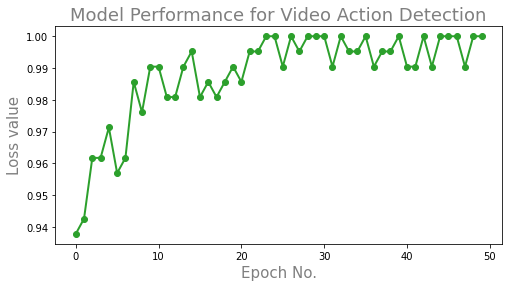

In [79]:
show_model_performance()

In [26]:
load_tracker = {"CNN_3D_Model":"n",
                "LSTM_Model":"n",
                "train_data":"n",
                "test_data":"n",
                }

for file_name in load_tracker:
    user_input = input("Load " + file_name + " y/n? ")
    load_tracker[file_name] = user_input

print('\n', load_tracker)

Load CNN_3D_Model y/n? n
Load LSTM_Model y/n? n
Load train_data y/n? n
Load test_data y/n? n

 {'CNN_3D_Model': 'n', 'LSTM_Model': 'n', 'train_data': 'n', 'test_data': 'n'}


In [50]:
model_id = int(input("Which model to run? '0' for 3D_CNN and '1' for LSTM? "))

model_name = 'CNN_3D_Model'

if model_id == 1:
    model_name = "LSTM_Model"

print('\nChosen Model: ' + model_name)

Which model to run? '0' for 3D_CNN and '1' for LSTM? 1

Chosen Model: LSTM_Model


In [51]:
!mv /content/Dataset/train /content/Dataset/Training_set

mv: cannot stat '/content/Dataset/train': No such file or directory


In [52]:
!mv /content/Dataset/val /content/Dataset/Testing_set

mv: cannot stat '/content/Dataset/val': No such file or directory


In [53]:
!cp -a /content/Dataset/Testing_set/Anomaly/. /content/Dataset/Testing_set

cp: cannot stat '/content/Dataset/Testing_set/Anomaly/.': No such file or directory


In [31]:
!cp -a /content/Dataset/Testing_set/Normal/. /content/Dataset/Testing_set

In [32]:

!mv /content/Dataset/Testing_set/Normal /content
!mv /content/Dataset/Testing_set/Anomaly /content

In [33]:
if load_tracker["train_data"] == "n":
    print("Reading Training Data..")
    trainingData_paths, y_train = read_train_data_paths()
    trainingData_paths, y_train = shuffle(trainingData_paths, y_train)

100%|██████████| 140/140 [00:00<00:00, 50778.50it/s]

Reading Training Data..


In [34]:
if load_tracker["train_data"] == "n":
    know_about_train_data(trainingData_paths)

100%|██████████| 209/209 [00:00<00:00, 592.07it/s]


We have 209  videos.
Videos are divided into  {'Anomaly': 69, 'Normal': 140}
Videos Shapes are:
(320.0, 240.0, 90.0)     6
(320.0, 240.0, 85.0)     5
(320.0, 240.0, 180.0)    5
(320.0, 240.0, 48.0)     4
(320.0, 240.0, 179.0)    4
                        ..
(260.0, 190.0, 102.0)    1
(78.0, 106.0, 106.0)     1
(320.0, 240.0, 67.0)     1
(320.0, 240.0, 167.0)    1
(320.0, 240.0, 140.0)    1
Length: 140, dtype: int64


In [35]:

if load_tracker["test_data"] == "n":
    print("Reading Testing Data..")
    testingData_paths = read_test_data_paths()

100%|██████████| 90/90 [00:00<00:00, 86778.70it/s]

Reading Testing Data..


In [36]:
if load_tracker["test_data"] == "n":
    know_about_test_data(testingData_paths)

100%|██████████| 90/90 [00:00<00:00, 1354.11it/s]


We have 90  videos.
Videos Shapes are:
(320.0, 240.0, 118.0)    2
(320.0, 240.0, 133.0)    2
(320.0, 240.0, 64.0)     2
(320.0, 240.0, 45.0)     2
(320.0, 240.0, 72.0)     2
                        ..
(320.0, 240.0, 75.0)     1
(320.0, 240.0, 32.0)     1
(125.0, 135.0, 369.0)    1
(161.0, 88.0, 58.0)      1
(303.0, 204.0, 250.0)    1
Length: 73, dtype: int64


In [37]:
%cd /content/Dataset 
!mkdir Structures

/content/Dataset


In [38]:
if load_tracker["train_data"] == "n":
    X_train, y_train = preprocess(trainingData_paths, y_train)
    save_structure(X_train, "X_train")
    save_structure(y_train, "y_train")
else:
    X_train = load_structure("X_train")
    y_train = load_structure("y_train")
    print("Training data is Loaded!")

100%|██████████| 209/209 [00:10<00:00, 19.17it/s]


In [81]:
y_test

NameError: ignored

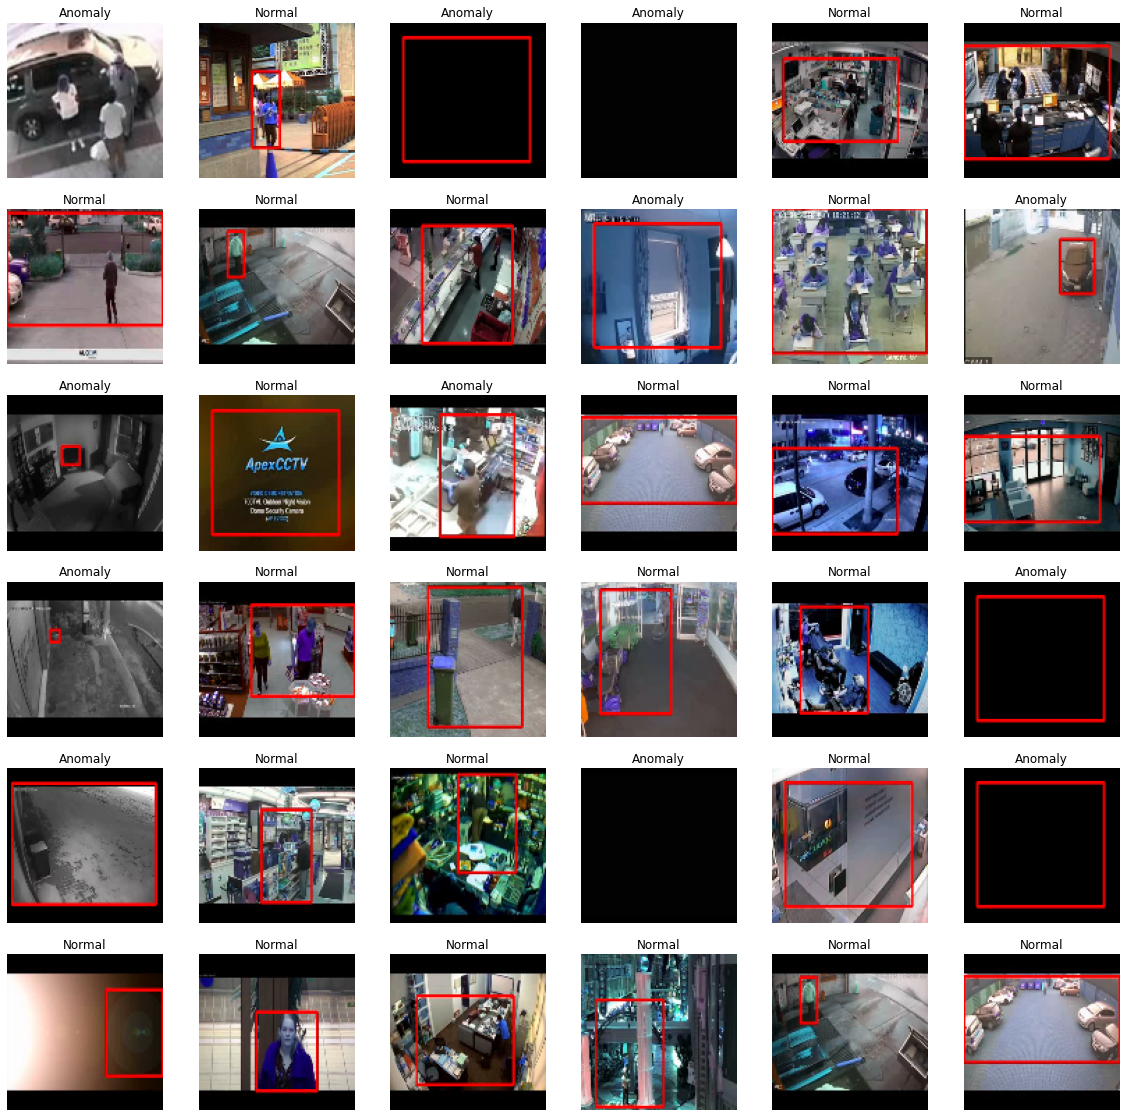

In [39]:
have_a_look(X_train, y_train)


In [40]:

if load_tracker["test_data"] == "n":
    X_test, _ = preprocess(testingData_paths, [])
    save_structure(X_test, "X_test")
else:
    X_test = load_structure("X_test")
    print("Testing data is Loaded")

100%|██████████| 90/90 [00:04<00:00, 18.47it/s]


In [78]:
X_test

array([[[[[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         ...,

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
          ...,
          [  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0]],

         [[  0,   0,   0],
          [  0,   0,   0],
          [  0,   0,   0],
         

In [41]:
y_train

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0], dtype=object)

In [42]:
def read_train_data_paths():
    data_paths = []
    truth = []

    for class_name in classes:
        for file in tqdm(os.listdir(train_path + "/" + class_name)):
            vid_path = os.path.join(train_path + "/" + class_name, file)
            data_paths.append(vid_path)
            truth.append(classes[class_name])
    
    return data_paths, truth



def read_test2_data_paths():
    data_paths = []
    truth = []

    for class_name in classes:
        for file in tqdm(os.listdir(test_path + "/" + class_name)):
            vid_path = os.path.join(test_path + "/" + class_name, file)
            data_paths.append(vid_path)
            truth.append(classes[class_name])
    
    return data_paths, truth


In [43]:
!mv /content/Weights /content/Dataset

In [44]:
pwd

'/content/Dataset'

In [45]:
%cd /content 
!mkdir Models
!mv /content/Models /content/Dataset
%cd /content/Dataset

/content
/content/Dataset


In [46]:
def show_model_performance():
    global model
    plot_model_metrics(model.history)

def show_summary():
    global model
    print(model.summary())

def save_model_plot(name):
    global model
    plot_model(model, to_file=name+'.png', show_shapes = True)    

In [48]:
import tensorflow as tf
import keras

KeyError: ignored

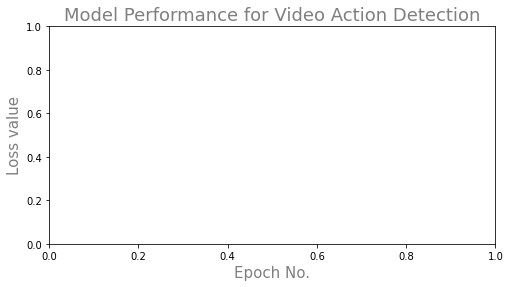

In [75]:
show_model_performance()

In [ ]:
if load_tracker[model_name] == "n":
    create_model(model_id)
    save_model_plot(model_name)
    print("Model is created!")
else:
    load_model(model_id)
    print("Model is loaded!")

show_summary()


258080768/258076736 [==============================] - 2s 0us/step


In [55]:
show_summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16, 112, 112, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 16, 4, 4, 2560)    64097687  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 40960)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               21037568  
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 85,135,513
Trainable params: 21,037,826
Non-trainable params: 64,097,687
______________________________________

In [56]:
history1 = train(X_train, y_train, val_split=0.2)
history1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


Epoch 1/50
4/4 [==============================] - 94s 10s/step - loss: 0.9766 - auc_1: 0.6092 - accuracy: 0.5906 - val_loss: 0.5531 - val_auc_1: 0.8118 - val_accuracy: 0.6905
Epoch 2/50
4/4 [==============================] - 10s 2s/step - loss: 0.5431 - auc_1: 0.8082 - accuracy: 0.7238 - val_loss: 0.5498 - val_auc_1: 0.8039 - val_accuracy: 0.6667
Epoch 3/50
4/4 [==============================] - 10s 2s/step - loss: 0.4399 - auc_1: 0.8898 - accuracy: 0.8372 - val_loss: 0.5781 - val_auc_1: 0.8039 - val_accuracy: 0.6667
Epoch 4/50
4/4 [==============================] - 10s 2s/step - loss: 0.4242 - auc_1: 0.8870 - accuracy: 0.8113 - val_loss: 0.5291 - val_auc_1: 0.8243 - val_accuracy: 0.7381
Epoch 5/50
4/4 [==============================] - 10s 2s/step - loss: 0.3456 - auc_1: 0.9364 - accuracy: 0.8925 - val_loss: 0.5263 - val_auc_1: 0.8328 - val_accuracy: 0.7143
Epoch 6/50
4/4 [==============================] - 10s 3s/step - loss: 0.3086 - auc_1: 0.9487 - accuracy: 0.8793 - val_loss: 0.533

In [57]:
pwd

'/content/Dataset'

In [76]:
train(X_train, y_train, val_split=0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


Epoch 1/50
5/5 [==============================] - 12s 2s/step - loss: 0.2249 - auc_1: 0.9723 - accuracy: 0.9378
Epoch 2/50
5/5 [==============================] - 10s 2s/step - loss: 0.1625 - auc_1: 0.9817 - accuracy: 0.9426
Epoch 3/50
5/5 [==============================] - 10s 2s/step - loss: 0.1513 - auc_1: 0.9820 - accuracy: 0.9617
Epoch 4/50
5/5 [==============================] - 10s 2s/step - loss: 0.1525 - auc_1: 0.9837 - accuracy: 0.9617
Epoch 5/50
5/5 [==============================] - 10s 2s/step - loss: 0.1337 - auc_1: 0.9886 - accuracy: 0.9713
Epoch 6/50
5/5 [==============================] - 10s 2s/step - loss: 0.1390 - auc_1: 0.9878 - accuracy: 0.9569
Epoch 7/50
5/5 [==============================] - 10s 2s/step - loss: 0.1260 - auc_1: 0.9938 - accuracy: 0.9617
Epoch 8/50
5/5 [==============================] - 10s 2s/step - loss: 0.1033 - auc_1: 0.9954 - accuracy: 0.9856
Epoch 9/50
5/5 [==============================] - 10s 2s/step - loss: 0.0942 - auc_1: 0.9956 - accuracy:

In [84]:
y_predict = predict(X_test)


In [85]:
y_predict

array([[2.6659280e-01, 7.3340720e-01],
       [5.9908085e-02, 9.4009185e-01],
       [7.3933369e-04, 9.9926060e-01],
       [4.3393276e-03, 9.9566060e-01],
       [8.6859864e-04, 9.9913138e-01],
       [9.9390501e-01, 6.0949996e-03],
       [3.1105208e-04, 9.9968898e-01],
       [9.9348152e-01, 6.5185553e-03],
       [1.4525351e-01, 8.5474646e-01],
       [5.4497056e-04, 9.9945503e-01],
       [3.5391107e-02, 9.6460885e-01],
       [3.6199223e-03, 9.9638015e-01],
       [9.9315780e-01, 6.8421466e-03],
       [3.9059753e-04, 9.9960941e-01],
       [3.0686904e-03, 9.9693131e-01],
       [1.1664152e-01, 8.8335848e-01],
       [9.3057245e-02, 9.0694273e-01],
       [5.7355378e-02, 9.4264466e-01],
       [9.9693739e-01, 3.0625842e-03],
       [3.6990476e-01, 6.3009524e-01],
       [2.4706112e-01, 7.5293887e-01],
       [5.8250298e-04, 9.9941754e-01],
       [9.9932098e-01, 6.7907199e-04],
       [3.5110028e-03, 9.9648905e-01],
       [1.3039999e-03, 9.9869603e-01],
       [7.5101014e-03, 9.

In [73]:
y_predict

array([[6.4962006e-01, 3.5037994e-01],
       [3.8722083e-01, 6.1277920e-01],
       [1.1713309e-03, 9.9882871e-01],
       [3.8929065e-03, 9.9610704e-01],
       [1.9788265e-03, 9.9802113e-01],
       [9.9348575e-01, 6.5142759e-03],
       [6.2110211e-04, 9.9937892e-01],
       [9.8917550e-01, 1.0824477e-02],
       [6.4810127e-02, 9.3518984e-01],
       [1.6369824e-03, 9.9836296e-01],
       [5.8618400e-02, 9.4138157e-01],
       [1.4011924e-02, 9.8598808e-01],
       [9.9104488e-01, 8.9551704e-03],
       [1.6660031e-03, 9.9833399e-01],
       [6.6376501e-03, 9.9336231e-01],
       [2.8321929e-03, 9.9716777e-01],
       [1.4888351e-01, 8.5111654e-01],
       [3.2485966e-02, 9.6751404e-01],
       [9.9675226e-01, 3.2477132e-03],
       [6.5835756e-01, 3.4164241e-01],
       [8.6900322e-03, 9.9131000e-01],
       [1.2064518e-03, 9.9879348e-01],
       [9.9880683e-01, 1.1932192e-03],
       [2.1348142e-03, 9.9786526e-01],
       [2.7266499e-03, 9.9727339e-01],
       [2.2670297e-02, 9.

In [62]:
pwd

'/content/Dataset'

In [87]:
create_predictions_csv_file(model_name, y_predict)


100%|██████████| 90/90 [00:00<00:00, 401582.30it/s]


In [ ]:
import pandas
colnames = ['year', 'name', 'city','ok']
data = pandas.read_csv('/content/Untitled spreadsheet - CNN_3D_Model_predictions.csv', names=colnames)

In [ ]:
data.name

0     0
1     1
2     1
3     1
4     1
     ..
85    1
86    1
87    0
88    0
89    1
Name: name, Length: 90, dtype: int64

In [ ]:
data.city

0     0
1     1
2     1
3     1
4     0
     ..
85    1
86    1
87    0
88    0
89    1
Name: city, Length: 90, dtype: int64

In [ ]:
test_labels = data.name
prediction = data.city

In [97]:
import pandas
colnames = ['year', 'name', 'city','ok']
data = pandas.read_csv('/content/LSTM_Model_predictions_EffecientNet7 - LSTM_Model_predictions_EffecientNet7.csv', names=colnames)

In [98]:
test_labels = data.name
prediction = data.city

In [99]:
test_labels

0     1
1     1
2     1
3     1
4     1
     ..
85    0
86    1
87    1
88    1
89    1
Name: name, Length: 90, dtype: int64

In [100]:
prediction

0     1
1     1
2     1
3     1
4     1
     ..
85    1
86    1
87    1
88    1
89    0
Name: city, Length: 90, dtype: int64

In [71]:


def predict(X_test):
  y_pred = model.predict(X_test)
  return y_pred

In [103]:
from sklearn.metrics import *
accuracy_score(test_labels,prediction)

0.7555555555555555

In [70]:
prediction

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
85   NaN
86   NaN
87   NaN
88   NaN
89   NaN
Name: city, Length: 90, dtype: float64

In [101]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels,prediction)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc


0.7533783783783784

In [64]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(X_test,y_predict)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc


ValueError: ignored

Text(0.5, 0, 'False Positive Rate')

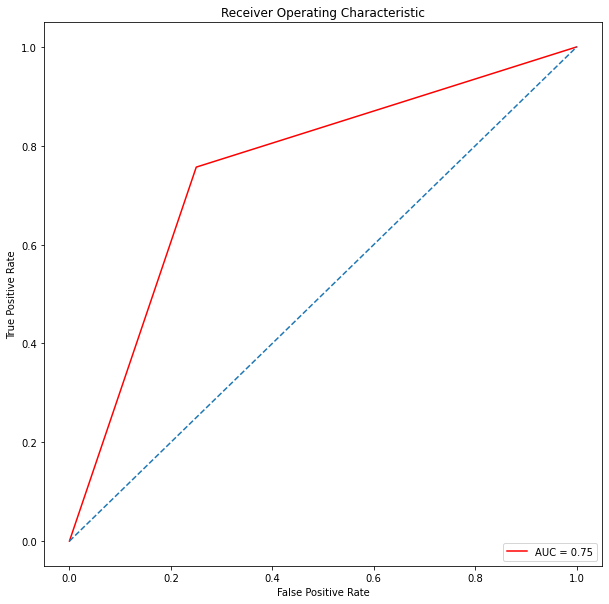

In [102]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


In [ ]:
import os

list = os.listdir('/content/All_Croped/Normal') # dir is your directory path
number_files = len(list)
print( number_files)

120


In [ ]:
# !rm -rf /content/Dataset

In [ ]:

import os
from random import sample

files = os.listdir('/content/All_Croped/Normal')
for file in sample(files,80):
    os.remove('/content/All_Croped/Normal/' +file)

In [ ]:
%cd /content 

/content


In [ ]:
import csv
with open('/content/Dataset/newwww.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        print(row)

FileNotFoundError: ignored

In [ ]:
import pandas
colnames = ['year', 'name', 'city','ok']
data = pandas.read_csv('/content/newwww.csv', names=colnames)

In [ ]:


names = data.name.tolist()
names

import numpy as np
my_array = np.array(names)
my_array

NameError: ignored

In [ ]:

cities = data.city.tolist()
cities
my_array1 = np.array(cities)
my_array1

NameError: ignored

In [ ]:


cities = data.ok.tolist()
cities
my_array2 = np.array(cities)
my_array2

array([0.2       , 0.4       , 0.3       , 0.2       , 0.1       ,
       0.3       , 0.4       , 0.6       , 0.1       , 0.        ,
       0.8       , 0.7       , 0.4       , 0.7889    , 0.3213    ,
       0.876     , 1.        , 0.7899    , 0.76      , 0.64      ,
       0.754654  , 0.89      , 0.8766123 , 0.76125351, 0.8972371 ,
       0.67123123, 0.56314534, 0.8935134 , 0.78394234, 0.34234234,
       0.82374728, 0.2342341 , 0.68234723, 0.8234234 , 0.89345   ,
       0.76125312, 0.6781239 , 0.9812737 , 0.31232341, 0.78391293,
       0.6123123 , 0.87126317, 0.891233  , 0.98123632, 0.71243673,
       0.8129312 , 0.724123  , 0.94812362, 0.8761236 , 0.67213   ,
       0.23131231, 0.5234124 , 0.61231231, 0.        , 0.1231231 ,
       0.2       , 0.62312312, 0.1       , 0.1       , 0.134     ,
       0.0012313 , 0.2       , 0.1       , 0.111     , 0.5324234 ,
       0.111     ])

In [ ]:
from sklearn.metrics import *
accuracy_score(my_array1, my_array)

0.7878787878787878

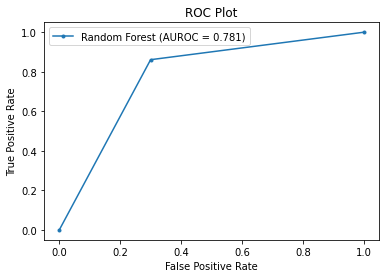

In [ ]:
r_auc = roc_auc_score(my_array1, my_array)
rf_fpr1, rf_tpr1, _ = roc_curve(my_array1, my_array)

import matplotlib.pyplot as plt
plt.plot(rf_fpr1, rf_tpr1, marker='.', label='Random Forest (AUROC = %0.3f)' % r_auc)


# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

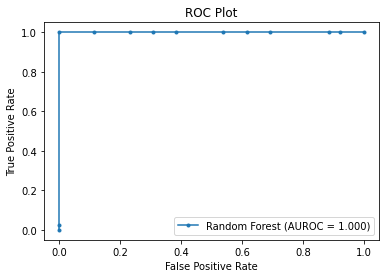

In [ ]:
r_auc = roc_auc_score(my_array , my_array2)
rf_fpr1, rf_tpr1, _ = roc_curve(my_array , my_array2)

import matplotlib.pyplot as plt
plt.plot(rf_fpr1, rf_tpr1, marker='.', label='Random Forest (AUROC = %0.3f)' % r_auc)


# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [ ]:
print(rf_fpr1, rf_tpr1)

[0.         0.         0.         0.11538462 0.23076923 0.30769231
 0.38461538 0.53846154 0.61538462 0.69230769 0.88461538 0.92307692
 1.        ] [0.    0.025 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.   ]


In [ ]:
f.ravel()

array([0.2  , 0.4  , 0.3  , 0.2  , 0.1  , 0.3  , 0.4  , 0.6  , 0.1  ,
       0.   , 0.8  , 0.7  , 0.4  , 0.789, 0.321, 0.876, 1.   , 0.79 ,
       0.76 , 0.64 , 0.755, 0.89 , 0.877, 0.761, 0.897, 0.671, 0.563,
       0.894, 0.784, 0.342, 0.824, 0.234, 0.682, 0.823, 0.893, 0.761,
       0.678, 0.981, 0.312, 0.784, 0.612, 0.871, 0.891, 0.981, 0.712,
       0.813, 0.724, 0.948, 0.876, 0.672, 0.231, 0.523, 0.612, 0.   ,
       0.123, 0.2  , 0.623, 0.1  , 0.1  , 0.134, 0.001, 0.2  , 0.1  ,
       0.111, 0.532, 0.111])

In [ ]:
rf_fpr, rf_tpr  , _ = roc_curve(my_array ,my_array1 )


In [ ]:
import numpy as np 
f = np.around(my_array1, decimals=0)

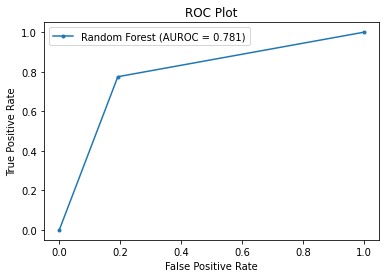

In [ ]:
rf_fpr, rf_tpr  , _ = roc_curve(my_array ,my_array1 )

import matplotlib.pyplot as plt
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % r_auc)


# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [ ]:
import pandas
colnames = ['year', 'name', 'city','ok']
data = pandas.read_csv('/content/newwww.csv', names=colnames)

names = data.name.tolist()
names

import numpy as np
my_array = np.array(names)
my_array

cities = data.city.tolist()
cities
my_array1 = np.array(cities)
my_array1

cities = data.ok.tolist()
cities
my_array2 = np.array(cities)
my_array2

array([0.43123123, 0.41231231, 0.4634535 , 0.42113123, 0.44123123,
       0.41231255, 0.46321312, 0.58923132, 0.43121231, 0.42351342,
       0.546     , 0.518     , 0.48      , 0.5342    , 0.4123    ,
       0.523423  , 0.523     , 0.512312  , 0.56      , 0.581231  ,
       0.5234    , 0.563     , 0.54234   , 0.6       , 0.56      ,
       0.5123    , 0.56314534, 0.566     , 0.512     , 0.477     ,
       0.542     , 0.498     , 0.54      , 0.512     , 0.56      ,
       0.59      , 0.511     , 0.57      , 0.46      , 0.55      ,
       0.53      , 0.5123    , 0.532     , 0.51      , 0.54      ,
       0.5123    , 0.567     , 0.512323  , 0.523     , 0.522     ,
       0.23131231, 0.5234124 , 0.61231231, 0.44      , 0.455     ,
       0.423     , 0.5867    , 0.4234    , 0.423312  , 0.487534  ,
       0.4776    , 0.41231   , 0.47875   , 0.498     , 0.548     ,
       0.454     ])

In [ ]:
cities = data.name.tolist()
cities
my_array1 = np.array(cities)
my_array1

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])

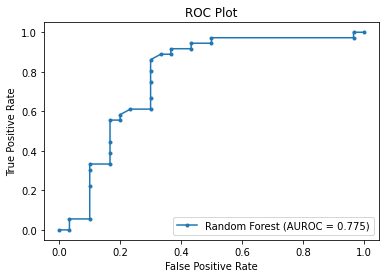

In [ ]:
r_auc = roc_auc_score(my_array1 , my_array2)

rf_fpr, rf_tpr  , _ = roc_curve(my_array1 ,my_array2 , pos_label=1)

import matplotlib.pyplot as plt
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % r_auc)


# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [ ]:
print(rf_fpr, rf_tpr)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.07692308 1.        ] [0.    0.025 0.275 0.35  0.475 0.525 0.675 0.725 0.825 0.9   0.95  1.
 1.    1.   ]
